In [94]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from tqdm import tqdm
from MLP import *
from CustomDataset import *


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on {device}')

Working on cuda


## Questão 1

### Importação dos dados e divisão entre treino e teste

In [3]:
data_np = pd.read_csv('concrete.csv', header=None).values
train, test = train_test_split(data_np, test_size = 0.2, shuffle=True, random_state=0)

### Divisão entre treino e validação

In [4]:
train_2, val = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)
train_2_scaler = StandardScaler()
train_2[:, :-1] = train_2_scaler.fit_transform(train_2[:, :-1])
val[:, :-1] = train_2_scaler.transform(val[:, :-1])

train_2_set = CustomDataset(train_2)
val_set = CustomDataset(val)

train_2_loader = DataLoader(train_2_set, batch_size = 32)
val_loader = DataLoader(val_set, batch_size = 32)

### Inicialização dos modelos

Fiz um grid-search simples usando o número de neurônios escondidos e o termo de momentum como hiperparâmetros

In [8]:
momentum_terms = {
    0 : 0.001,
    1 : 0.003,
    2 : 0.006,
    3 : 0.01
}

models = [[[MLP(8, 4**i, 1).to(device), None] for i in range(4)] for j in range(4)]
criterion = torch.nn.MSELoss()
for i in range(4):
    for j in range(4):
        models[i][j][1] = torch.optim.SGD(models[i][j][0].parameters(), lr = 0.001, momentum = momentum_terms[j])

### Inicialização da lista que armazenará o valor da função custo para cada modelo

In [9]:
loss_list = [[[list() for i in range(4)] for j in range(4)] for k in range(2)]

### Treinamento dos modelos

In [10]:
for i in range(4):
    for j in range(4):
        for epoch in range(400):
            for index, (attributes, labels) in enumerate(train_2_loader):
                attributes = attributes.to(device)
                labels = labels.to(device)
                
                outputs = models[i][j][0](attributes)
                loss = criterion(outputs[:, 0], labels)
                
                models[i][j][1].zero_grad()
                loss.backward()
                models[i][j][1].step()
            
            loss_list[0][i][j].append(loss.item())

            for index, (attributes, labels) in enumerate(val_loader):
                attributes = attributes.to(device)
                labels = labels.to(device)

                outputs = models[i][j][0](attributes)
                loss = criterion(outputs[:, 0], labels)
            
            loss_list[1][i][j].append(loss.item())

        print(f'Model with {4**i} neurons and momentum rate = {momentum_terms[j]} trained.')

Model with 1 neurons and momentum rate = 0.001 trained.
Model with 1 neurons and momentum rate = 0.003 trained.
Model with 1 neurons and momentum rate = 0.006 trained.
Model with 1 neurons and momentum rate = 0.01 trained.
Model with 4 neurons and momentum rate = 0.001 trained.
Model with 4 neurons and momentum rate = 0.003 trained.
Model with 4 neurons and momentum rate = 0.006 trained.
Model with 4 neurons and momentum rate = 0.01 trained.
Model with 16 neurons and momentum rate = 0.001 trained.
Model with 16 neurons and momentum rate = 0.003 trained.
Model with 16 neurons and momentum rate = 0.006 trained.
Model with 16 neurons and momentum rate = 0.01 trained.
Model with 64 neurons and momentum rate = 0.001 trained.
Model with 64 neurons and momentum rate = 0.003 trained.
Model with 64 neurons and momentum rate = 0.006 trained.
Model with 64 neurons and momentum rate = 0.01 trained.


### PLOTANDO AS FUNÇÕES CUSTOS!

Já que o senhor gosta tanto, pois tome logo 16 gráficos de uma vez!

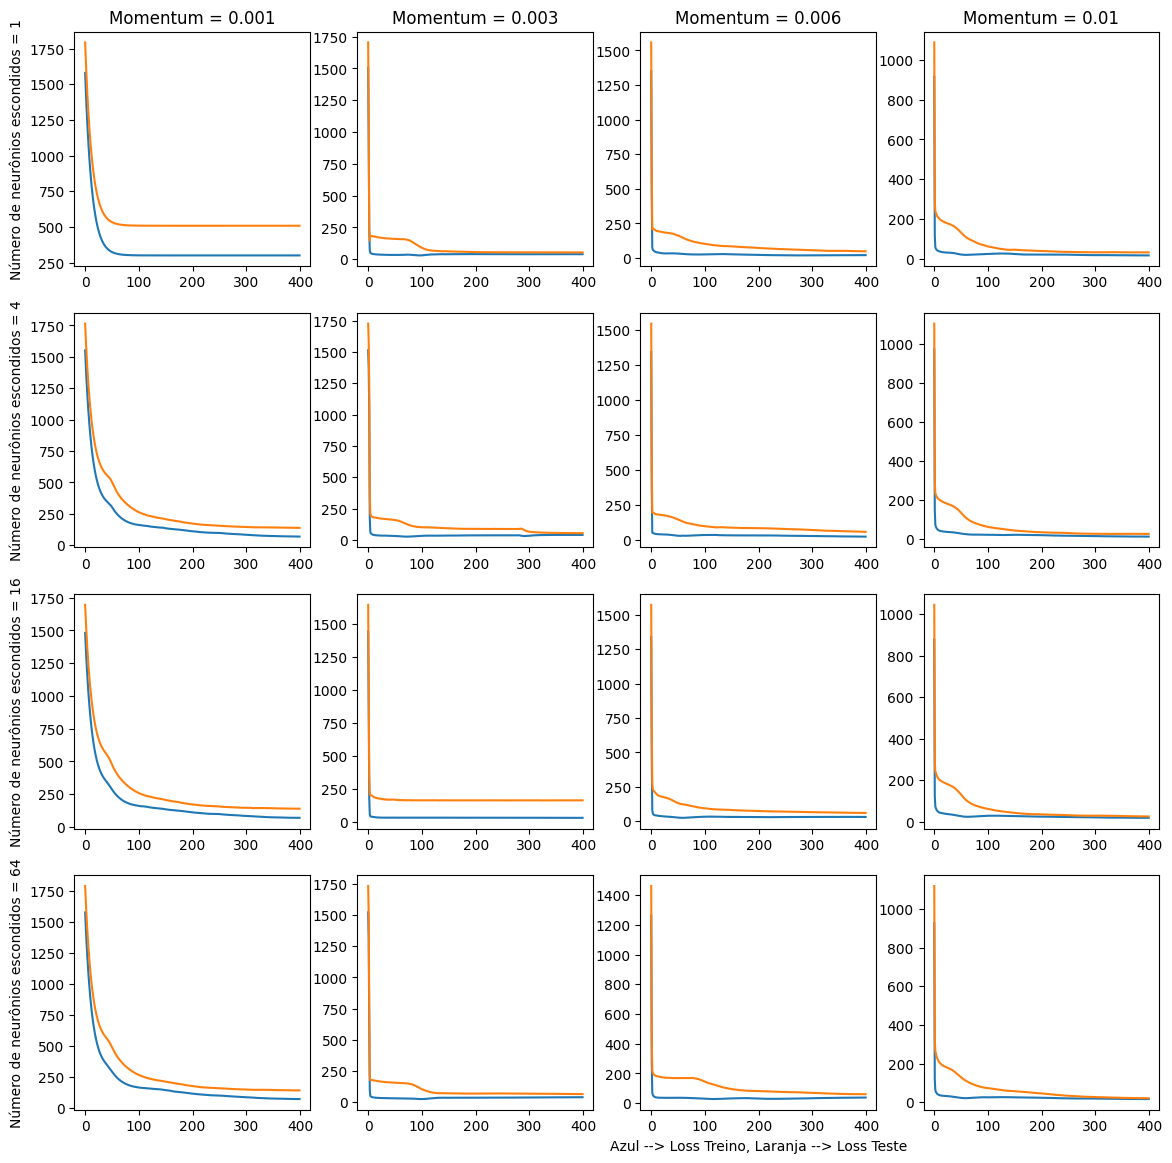

In [11]:
fig, ax = plt.subplots(4, 4, figsize=(14, 14))

for i in range(4):
    for j in range(4):
        ax[i][j].plot(range(len(loss_list[0][i][j])), loss_list[0][i][j])
        ax[i][j].plot(range(len(loss_list[1][i][j])), loss_list[1][i][j])

for i in range(4):
    ax[0][i].set_title(f'Momentum = {momentum_terms[i]}')
    ax[i][0].set_ylabel(f'Número de neurônios escondidos = {4**i}')

ax[-1][-2].set_xlabel('Azul --> Loss Treino, Laranja --> Loss Teste')

plt.show()

### Coletando os erros

In [16]:
train_rmse = torch.zeros((4, 4)).to(device)
train_mae = torch.zeros((4, 4)).to(device)
val_rmse = torch.zeros((4, 4)).to(device)
val_mae = torch.zeros((4, 4)).to(device)

for i in range(4):
    for j in range(4):
        train_out = models[i][j][0](torch.from_numpy(train_2[:, :-1]).to(torch.float32).to(device))
        train_real = torch.from_numpy(train_2[:, -1]).to(torch.float32).to(device)

        val_out = models[i][j][0](torch.from_numpy(val[:, :-1]).to(torch.float32).to(device))
        val_real = torch.from_numpy(val[:, -1]).to(torch.float32).to(device)

        train_rmse[i][j] = torch.sqrt(torch.nn.functional.mse_loss(train_out, train_real.reshape(-1, 1)))
        train_mae[i][j] = torch.nn.functional.l1_loss(train_out, train_real.reshape(-1, 1))

        val_rmse[i][j] = torch.sqrt(torch.nn.functional.mse_loss(val_out, val_real.reshape(-1, 1)))
        val_mae[i][j] = torch.nn.functional.l1_loss(val_out, val_real.reshape(-1, 1))


### Plotando os erros de treino e teste

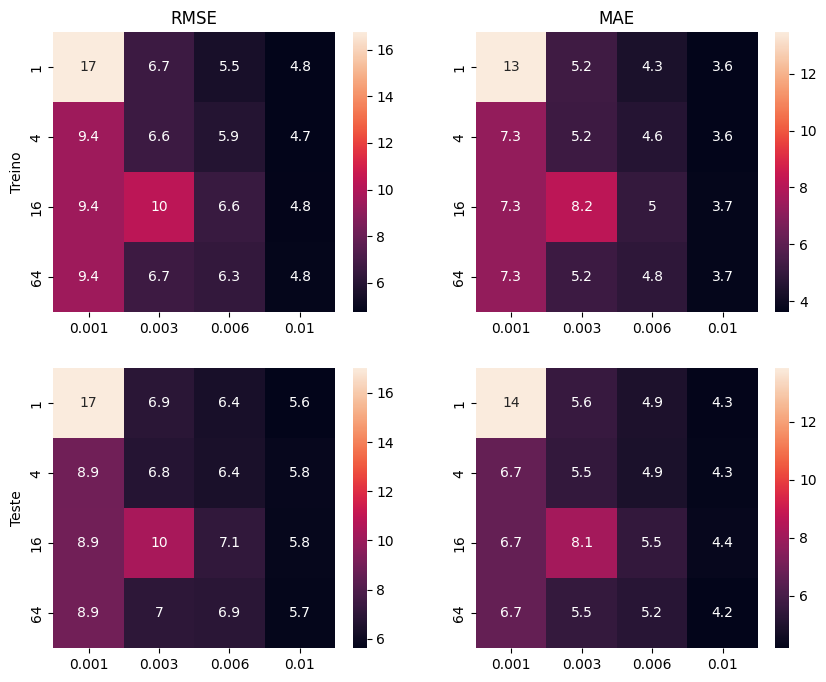

In [20]:
ylabels = [f'{4**i}' for i in range(4)]
xlabels = [f'{momentum_terms[i]}' for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

rmse_val = sns.heatmap(train_rmse.cpu().detach().numpy(), annot=True, ax=ax[0][0], xticklabels=xlabels, yticklabels=ylabels)
mae_val = sns.heatmap(train_mae.cpu().detach().numpy(), annot=True, ax=ax[0][1], xticklabels=xlabels, yticklabels=ylabels)
rmse_val = sns.heatmap(val_rmse.cpu().detach().numpy(), annot=True, ax=ax[1][0], xticklabels=xlabels, yticklabels=ylabels)
mae_val = sns.heatmap(val_mae.cpu().detach().numpy(), annot=True, ax=ax[1][1], xticklabels=xlabels, yticklabels=ylabels)

ax[0][0].set_title('RMSE')
ax[0][1].set_title('MAE')
ax[0][0].set_ylabel('Treino')
ax[1][0].set_ylabel('Teste')

plt.show()

### Utilizando os melhores hiperparâmetros para treinar na partição de treino completa

In [21]:
train_scaler = StandardScaler()
train[:, :-1] = train_scaler.fit_transform(train[:, :-1])
test[:, :-1] = train_scaler.transform(test[:, :-1])

train_set = CustomDataset(train)
test_set = CustomDataset(test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [51]:
model = MLP(8, 64, 1).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.1)

In [52]:
loss_list = [list() for i in range(2)]

In [53]:
for epoch in range(400):
    for index, (attributes, labels) in enumerate(train_loader):
        attributes = attributes.to(device)
        labels = labels.to(device)
        
        outputs = model(attributes)
        loss = criterion(outputs[:, 0], labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_list[0].append(loss.item())

    for index, (attributes, labels) in enumerate(test_loader):
        attributes = attributes.to(device)
        labels = labels.to(device)

        outputs = model(attributes)
        loss = criterion(outputs[:, 0], labels)
    
    loss_list[1].append(loss.item())

    print(f'Epoch {epoch+1}/100, Train Loss: {loss_list[0][-1]}, Test Loss: {loss_list[1][-1]}')

Epoch 1/100, Train Loss: 589.9323120117188, Test Loss: 290.1896057128906
Epoch 2/100, Train Loss: 99.43993377685547, Test Loss: 76.6081771850586
Epoch 3/100, Train Loss: 149.27508544921875, Test Loss: 131.40013122558594
Epoch 4/100, Train Loss: 84.55490112304688, Test Loss: 101.92516326904297
Epoch 5/100, Train Loss: 112.81529235839844, Test Loss: 103.65349578857422
Epoch 6/100, Train Loss: 126.94329071044922, Test Loss: 147.9219970703125
Epoch 7/100, Train Loss: 147.2391357421875, Test Loss: 99.80183410644531
Epoch 8/100, Train Loss: 124.47801208496094, Test Loss: 79.50114440917969
Epoch 9/100, Train Loss: 92.06413269042969, Test Loss: 110.31376647949219
Epoch 10/100, Train Loss: 137.2479248046875, Test Loss: 81.305419921875
Epoch 11/100, Train Loss: 153.40792846679688, Test Loss: 153.03958129882812
Epoch 12/100, Train Loss: 81.00627136230469, Test Loss: 139.14190673828125
Epoch 13/100, Train Loss: 100.926513671875, Test Loss: 89.0601577758789
Epoch 14/100, Train Loss: 91.489921569824

### Mais uma função custo!

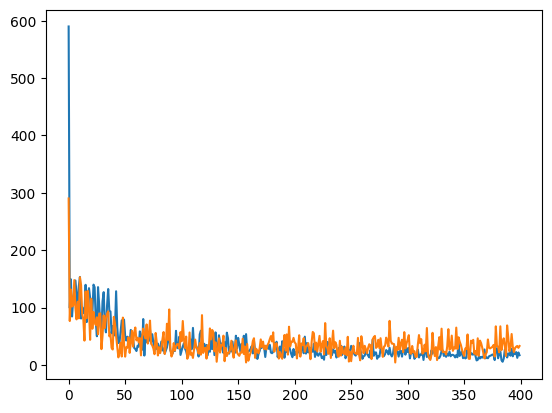

In [54]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_list[0])), loss_list[0])
plt.plot(range(len(loss_list[1])), loss_list[1])
plt.show()

In [55]:
metrics = torch.zeros((2, 2)).to(device)

train_out = model(torch.from_numpy(train[:, :-1]).to(torch.float32).to(device))
train_real = torch.from_numpy(train[:, -1]).to(torch.float32).to(device).reshape(-1, 1)
test_out = model(torch.from_numpy(test[:, :-1]).to(torch.float32).to(device))
test_real = torch.from_numpy(test[:, -1]).to(torch.float32).to(device).reshape(-1, 1)

metrics[0][0] = torch.sqrt(torch.nn.functional.mse_loss(train_out, train_real))
metrics[0][1] = torch.nn.functional.l1_loss(train_out, train_real)
metrics[1][0] = torch.sqrt(torch.nn.functional.mse_loss(test_out, test_real))
metrics[1][1] = torch.nn.functional.l1_loss(test_out, test_real)


### Mais valores descritivos.

/tmp/ipykernel_823/8510636.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


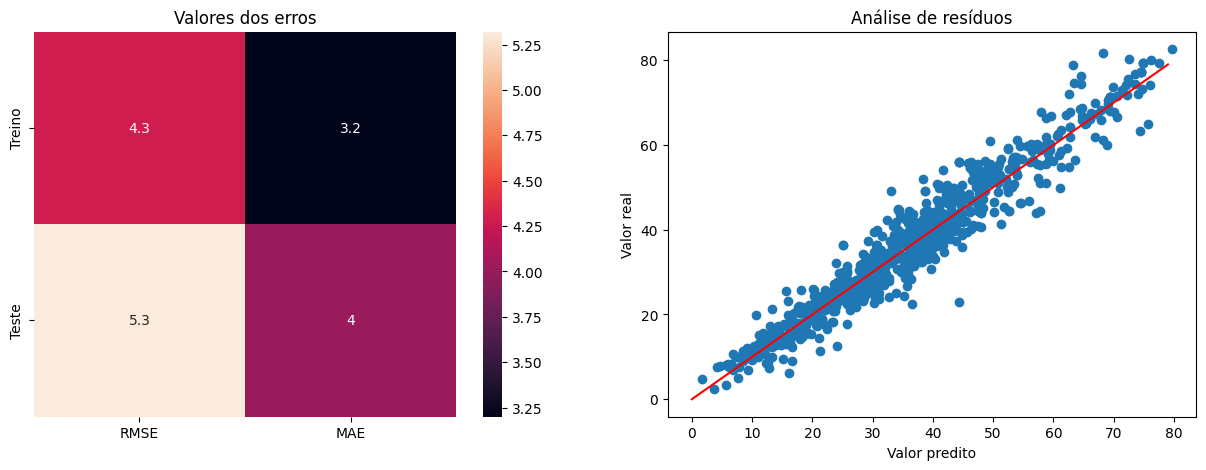

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

xlabels = ['RMSE', 'MAE']
ylabels = ['Treino', 'Teste']

hm = sns.heatmap(metrics.cpu().detach().numpy(), annot=True, xticklabels=xlabels, yticklabels=ylabels, ax=ax[0])
ax[0].set_title('Valores dos erros')
ax[1].scatter(train_out.cpu().detach().numpy(), train_real.cpu().detach().numpy())
ax[1].plot(range(80), range(80), c='r')
ax[1].set_title('Análise de resíduos')
ax[1].set_ylabel('Valor real')
ax[1].set_xlabel('Valor predito')

fig.show()

## Questão 2

### Importação dos dados, aplicando One Hot Encoding e divisão entre treino e teste

In [21]:
data_np = pd.read_csv('vowel.csv', header=None).values
train, test = train_test_split(data_np, test_size = 0.2, shuffle=True, random_state=0)

### Divisão entre treino e validação

In [129]:
train_2, val = train_test_split(train, test_size=0.25, shuffle=True, random_state=0)
train_2_scaler = StandardScaler()
train_2[:, :-1] = train_2_scaler.fit_transform(train_2[:, :-1])
val[:, :-1] = train_2_scaler.transform(val[:, :-1])

train_2_set = CustomDataset(train_2)
val_set = CustomDataset(val)

train_2_loader = DataLoader(train_2_set, batch_size = 32)
val_loader = DataLoader(val_set, batch_size = 32)

### Inicialização dos modelos

In [134]:
momentum_terms = {
    0 : 0.003,
    1 : 0.01,
}

hidden_terms = {
    0 : 256,
    1 : 1024
}

models = [[[MLP(10, hidden_terms[i], 11).to(device), None] for i in range(2)] for j in range(2)]
criterion = torch.nn.CrossEntropyLoss()
for i in range(2):
    for j in range(2):
        models[i][j][1] = torch.optim.SGD(models[i][j][0].parameters(), lr = 0.01, momentum = momentum_terms[j])

### Inicialização da lista que armazenará as funções custo

In [135]:
loss_list = [[[list() for i in range(2)] for j in range(2)] for k in range(2)]

### Treinando os modelos

In [136]:
for i in range(2):
    for j in range(2):
        for epoch in tqdm(range(2000)):
            for index, (attributes, labels) in enumerate(train_2_loader):
                attributes = attributes.to(device)
                labels = labels.to(device)
                
                outputs = (models[i][j][0](attributes).softmax(dim=1))
                loss = criterion(outputs, labels.to(torch.int64))
                
                models[i][j][1].zero_grad()
                loss.backward()
                models[i][j][1].step()
            
            loss_list[0][i][j].append(loss.item())

            for index, (attributes, labels) in enumerate(val_loader):
                attributes = attributes.to(device)
                labels = labels.to(device)

                outputs = models[i][j][0](attributes).softmax(dim=1)
                loss = criterion(outputs, labels.to(torch.int64))
            
            loss_list[1][i][j].append(loss.item())

        print(f'Model with {4**i} neurons and momentum rate = {momentum_terms[j]} trained.')

100%|██████████| 2000/2000 [01:59<00:00, 16.70it/s]


Model with 1 neurons and momentum rate = 0.003 trained.


100%|██████████| 2000/2000 [02:30<00:00, 13.32it/s]


Model with 1 neurons and momentum rate = 0.01 trained.


100%|██████████| 2000/2000 [01:59<00:00, 16.71it/s]


Model with 4 neurons and momentum rate = 0.003 trained.


100%|██████████| 2000/2000 [02:31<00:00, 13.17it/s]

Model with 4 neurons and momentum rate = 0.01 trained.


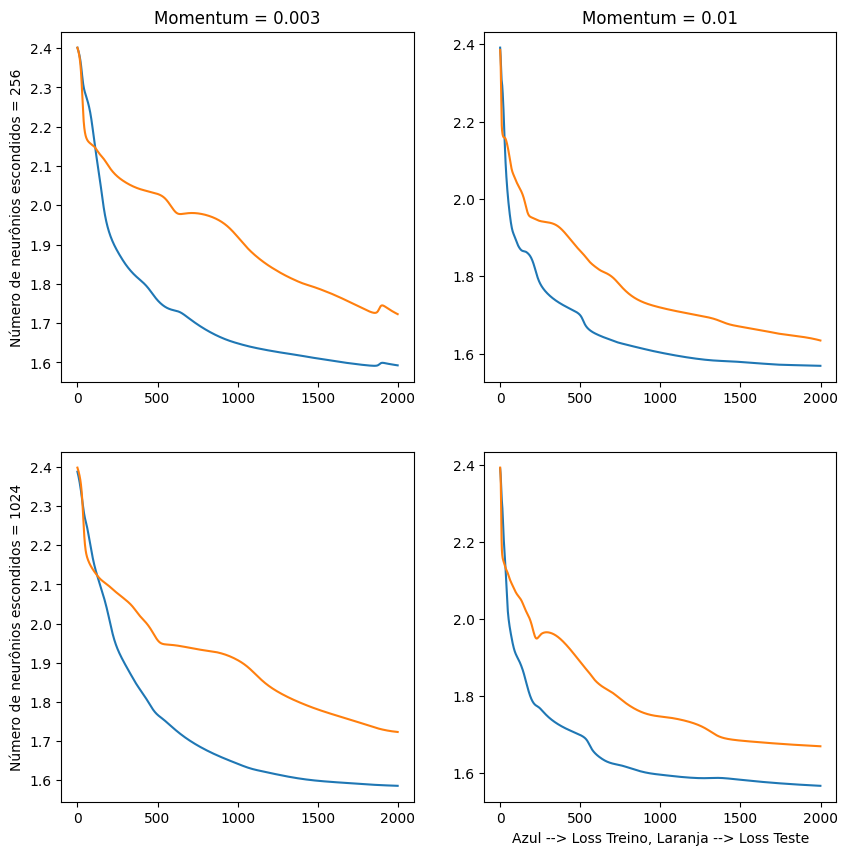

In [137]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        ax[i][j].plot(range(len(loss_list[0][i][j])), loss_list[0][i][j])
        ax[i][j].plot(range(len(loss_list[1][i][j])), loss_list[1][i][j])

for i in range(2):
    ax[0][i].set_title(f'Momentum = {momentum_terms[i]}')
    ax[i][0].set_ylabel(f'Número de neurônios escondidos = {hidden_terms[i]}')

ax[-1][-1].set_xlabel('Azul --> Loss Treino, Laranja --> Loss Teste')

plt.show()

In [165]:
train_scaler = StandardScaler()
train[:, :-1] = train_scaler.fit_transform(train[:, :-1])
test[:, :-1] = train_scaler.transform(test[:, :-1])

train_set = CustomDataset(train)
test_set = CustomDataset(test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [166]:
model = MLP(10, 256, 11).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.1)

In [167]:
loss_list = [list() for i in range(2)]

In [168]:
for epoch in range(2000):
    for index, (attributes, labels) in enumerate(train_loader):
        attributes = attributes.to(device)
        labels = labels.to(device)
        
        outputs = (model(attributes).softmax(dim=1))
        loss = criterion(outputs, labels.to(torch.int64))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_list[0].append(loss.item())

    for index, (attributes, labels) in enumerate(test_loader):
        attributes = attributes.to(device)
        labels = labels.to(device)

        outputs = (model(attributes).softmax(dim=1))
        loss = criterion(outputs, labels.to(torch.int64))
    
    loss_list[1].append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/2000, Train Loss: {loss_list[0][-1]}, Test Loss: {loss_list[1][-1]}')

Epoch 100/2000, Train Loss: 2.1626203060150146, Test Loss: 2.0132038593292236
Epoch 200/2000, Train Loss: 2.0576179027557373, Test Loss: 2.0664920806884766
Epoch 300/2000, Train Loss: 1.9823914766311646, Test Loss: 2.1535251140594482
Epoch 400/2000, Train Loss: 1.858796238899231, Test Loss: 1.9885135889053345
Epoch 500/2000, Train Loss: 1.8178540468215942, Test Loss: 2.2012081146240234
Epoch 600/2000, Train Loss: 1.8143649101257324, Test Loss: 2.0076332092285156
Epoch 700/2000, Train Loss: 1.7418394088745117, Test Loss: 1.8797756433486938
Epoch 800/2000, Train Loss: 1.714342713356018, Test Loss: 1.8383334875106812
Epoch 900/2000, Train Loss: 1.79921293258667, Test Loss: 1.9174178838729858
Epoch 1000/2000, Train Loss: 1.6573805809020996, Test Loss: 1.8570455312728882
Epoch 1100/2000, Train Loss: 1.7004313468933105, Test Loss: 1.7173724174499512
Epoch 1200/2000, Train Loss: 1.6350187063217163, Test Loss: 1.6599626541137695
Epoch 1300/2000, Train Loss: 1.645351767539978, Test Loss: 1.8970

In [180]:
out = model(torch.from_numpy(test[:, :-1]).to(device).to(torch.float32))
out = torch.argmax(out, axis=1)
out = out.cpu().detach().numpy()

In [182]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(test[:, -1], out)
cm = confusion_matrix(test[:, -1], out)

In [184]:
cm

array([[13,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0],
       [ 0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 17,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  1,  0, 17,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  5, 12,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 16,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 17,  0,  6],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 17,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 23]])